# River Flow Dataset
We assume that the flow of our river on day _t_ depends on two factors:

- The melting rate of an upstream glacier _t_ – 5 days ago.
- The rainfalls during the last 5 days (from _t_ – 4 to _t_).

We want to forecast the flow 10 days in advance. Furthermore, we assume that:
- The glacier’s melting rate is not known in advance because we have to measure it directly in order to know it; it is thus a past covariate.
- The rainfall is known 10 days in advance from weather forecasts. It is thus a future covariate. It is also known in the past.


Source: https://github.com/hrzn/medium_river_flow/blob/main/river-flow.ipynb

In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from darts.utils import timeseries_generation as tg

In [19]:
dataset_name = "river_flow"

In [20]:
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Generate Data

In [21]:
np.random.seed(42)

LENGTH = 3 * 365  # 3 years of daily data

# Melting: a sine with yearly periodicity and additive white noise
melting = (0.9 * tg.sine_timeseries(length=LENGTH, value_frequency=(1/365), 
                              freq='D', 
                              column_name='melting')
           + 0.1 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# Rainfalls: a sine with bi-weekly periodicity and additive white noise
rainfalls = (0.5 * tg.sine_timeseries(length=LENGTH, 
                                value_frequency=(1/14), 
                                freq='D', 
                                column_name='rainfall')
             + 0.5 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# We shift the melting by 5 days
melting_contribution = 0.5 * melting.shift(5)

# We compute similar contribution from the rainfalls
all_contributions = [melting_contribution] + [0.1 * rainfalls.shift(lag) for lag in range(5)]

# We compute the final flow as the sum of everything; trimming series so they
# all have the same start time
flow = sum([series[melting_contribution.start_time():][:melting.end_time()]
            for series in all_contributions]).with_columns_renamed('melting', 'flow')

# add some white noise
flow += 0.1 * tg.gaussian_timeseries(length=len(flow))

## Convert to Pandas DataFrame

In [22]:
data = flow.pd_dataframe().reset_index()
data.rename(columns={"time": "date"}, inplace=True)
data.insert(0, 'series', "river_flow")
data['melting'] = melting.values()[5:, 0]
data['rainfalls'] = rainfalls.values()[5:, 0]
data.head()

component,series,date,flow,melting,rainfalls
0,river_flow,2000-01-06,0.079456,0.053955,0.889921
1,river_flow,2000-01-07,0.112739,0.250713,-1.231186
2,river_flow,2000-01-08,0.481231,0.184931,1.044187
3,river_flow,2000-01-09,0.070752,0.076603,-0.286737
4,river_flow,2000-01-10,0.096160,0.193134,0.163176


In [23]:
series_col = "series"
epoch_col = 'date'
time_col = 'date'
value_col = 'flow'
exog_cols=['melting', 'rainfalls']

# Visualize

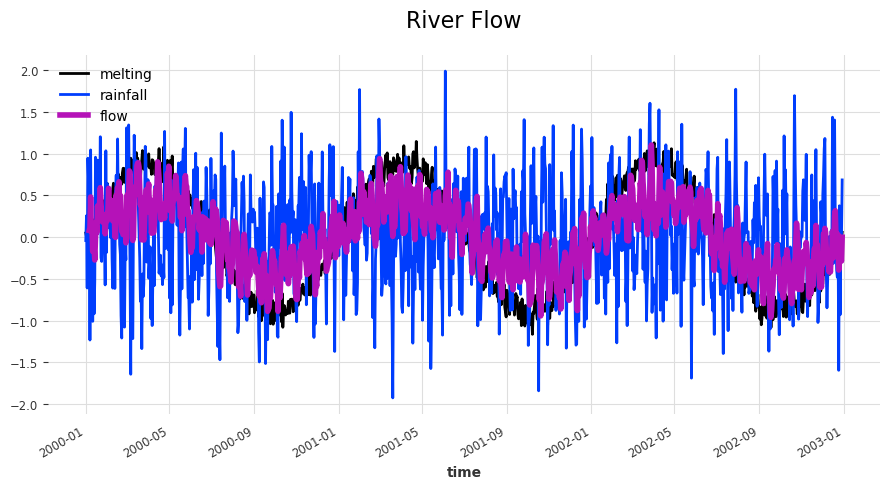

In [24]:
plt.figure(figsize=(9,5))
melting.plot()
rainfalls.plot()
flow.plot(lw=4)
plt.title("River Flow", fontsize=16, pad=20)
plt.tight_layout()
plt.legend(loc='upper left')
plt.savefig(outp_fig_fname)

# Save Main Data File

In [25]:
data.to_csv(outp_fname, index=False, float_format="%.3f")